In [4]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('./datas/例5-2.txt',sep='\t')
dataset.set_index('地区',inplace=True)

index = dataset.index
labels = dataset.columns
# 标准化
matrix = (dataset - np.mean(dataset, axis=0)) / np.std(dataset, axis=0)
# 求取相关阵
cor = np.corrcoef(matrix, rowvar=False)
# 求特征值与特征向量
eigvalue, eigvector = np.linalg.eig(cor)

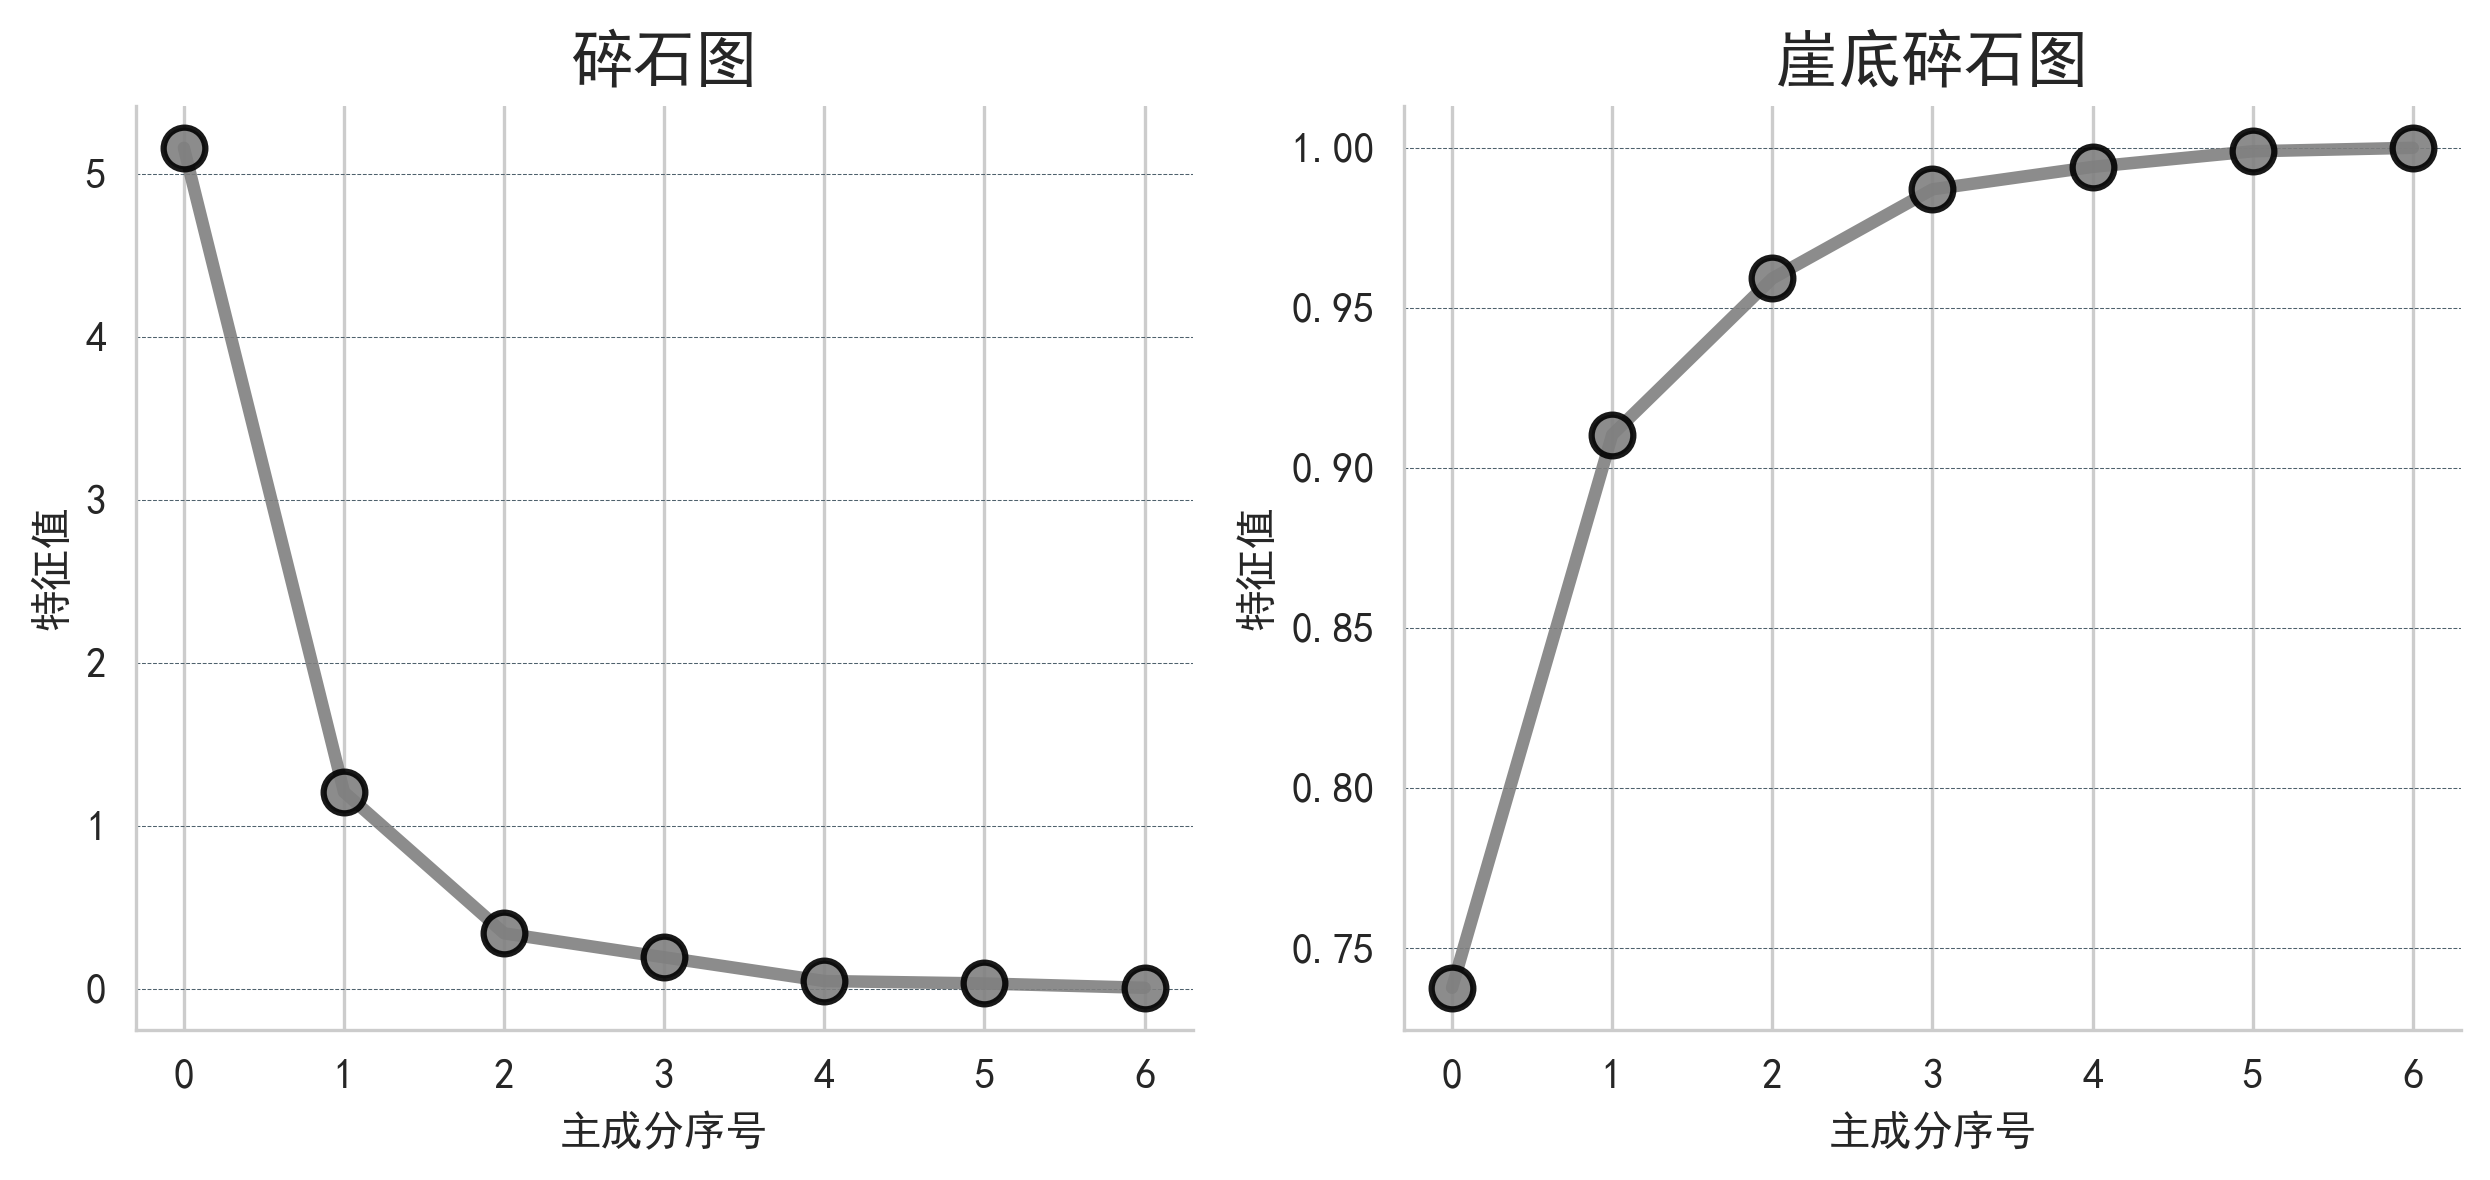

In [5]:
# 主成分法因子分析——观察碎石图
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False    # 用来正常显示负号

fa = FactorAnalyzer(rotation=None, method='principal')
fa.fit(dataset)
Eigvalue = pd.Series(eigvalue, index=labels)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=300)
ax1.grid(ls = "--",axis='y', lw = 0.25, color = "#4E616C")
names = [i for i in range(len(Eigvalue))]
ax1.plot(names, Eigvalue, linestyle='-', linewidth=3, color='grey', marker = "o",markeredgecolor='k',alpha=0.9,markersize='10',markeredgewidth=1.5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlabel("主成分序号")
ax1.set_ylabel("特征值")
ax1.set_title("碎石图", fontsize=15)
xx = Eigvalue/Eigvalue.sum()

ax2.grid(ls = "--", axis='y', lw = 0.25, color = "#4E616C")
ax2.plot(names, xx.cumsum(),linestyle='-', linewidth=3, color='grey', marker = "o",markeredgecolor='k',alpha=0.9,markersize='10',markeredgewidth=1.5)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel("主成分序号")
ax2.set_ylabel("特征值")
ax2.set_title("崖底碎石图", fontsize=15)
# ax2.axhline(y=0.93, xmin=-1.5, xmax=10, color='black', linestyle=':')
plt.show()

为公共因子$F_i$还需满足条件方差为1，通过将$Y_i$除以其标准差（特征根的平方根$\sqrt{\lambda_i}$）可以实现，令$F_i=Y_i/\sqrt{\lambda_i}$，且$a_{ij}=\sqrt{\lambda_j}\gamma_{ji}$

设$\lambda_1,\lambda_2,...,\lambda_p(\lambda_1\geq \lambda_2 \geq ... \geq \lambda_p)$为样本相关阵$\mathbf{R}$的特征根，$\gamma_1,\gamma_2,...,\gamma_p$为对应的标准正交化特征向量，设$m<p$，则因子载荷矩阵$\mathbf{A}$的一个解为：
$$
\hat{A}=(\sqrt{\lambda_1}\gamma_1,\sqrt{\lambda_2}\gamma_2,...,\sqrt{\lambda_m}\gamma_m)
$$

In [6]:
# 求未旋转的因子载荷
n_factors=2
# 取出前两个特征值，将其对角化
eigmat = np.diag(np.sqrt(eigvalue[:n_factors]))
# 特征向量分别矩阵乘 对角化矩阵
loadings = pd.DataFrame(eigvector[:,:n_factors].dot(eigmat), index=labels)
# 载荷矩阵
loadings

,0,1
X1,0.925004,0.047992
X2,0.930640,-0.170441
X3,0.957198,-0.196070
X4,0.908731,-0.296301
X5,0.968678,0.077472
X6,0.856380,0.395319
X7,0.167094,0.943014


得到初始载荷矩阵与公共因子之后，为了解释方便，往往需要对因子进行旋转，旋转方式有很多，自己实现太费时间，后续将引入第三方模块 factor_analyzer 中的FactorAnalyzer对象来帮助实现因子旋转

In [12]:
# 因子得分系数矩阵(用标准化原始变量表示标准化主成分(公共因子)的系数矩阵。)
# 因子得分系数矩阵
# weights_ = np.linalg.solve(cor, loadings)
# weights_ = np.linalg.inv(cor).dot(loadings)

# 之所以是除以方差而非标准差，是因为公共因子是标准化的主成分。
weights_ = loadings/np.array(eigvalue[:n_factors])
print('由该得分系数矩阵可得两个公共因子关于标准化原始变量的线性表达式分别为:')
for i in range(weights_.shape[1]):
    k = weights_.iloc[:, i]
    ss = [f'{k[f"X{j+1}"]:+.3f}' + f'*X{j+1}' for j in range(weights_.shape[0])]
    print(f'F{i+1}={"".join(ss) if "".join(ss).startswith("-") else "".join(ss)[1:]}')

weights_

由该得分系数矩阵可得两个公共因子关于标准化原始变量的线性表达式分别为:
F1=0.179*X1+0.180*X2+0.185*X3+0.176*X4+0.188*X5+0.166*X6+0.032*X7
F2=0.040*X1-0.141*X2-0.162*X3-0.245*X4+0.064*X5+0.327*X6+0.780*X7


,0,1
X1,0.179147,0.039691
X2,0.180238,-0.140960
X3,0.185382,-0.162156
X4,0.175995,-0.245050
X5,0.187605,0.064072
X6,0.165856,0.326941
X7,0.032361,0.779902


In [13]:
contributing = np.square(loadings)
h_2 = np.sum(np.array(np.square(loadings)))/sum(eigvalue)
print(f'公共因子的方差解释比例共同度为：{h_2:.2%}')
print(f'特殊因子方差解释比例特殊度为：{1-h_2:.2%}')
print(f'主因子1与主因子2分别对7个X的贡献度为:\n{np.sum(np.square(loadings),axis=1).values}')
print(f'主因子1与主因子2分别对7个X的提供的方差综合分别为:\n{np.sum(np.square(loadings),axis=0).values}')
# 两个主成分对原始各变量的方差贡献率为
contributing

公共因子的方差解释比例共同度为：91.04%
特殊因子方差解释比例特殊度为：8.96%
主因子1与主因子2分别对7个X的贡献度为:
[0.8579358  0.8951412  0.95467195 0.91358691 0.94433877 0.88966377
 0.91719529]
主因子1与主因子2分别对7个X的提供的方差综合分别为:
[5.16338922 1.20914446]


,0,1
X1,0.855633,0.002303
X2,0.866091,0.029050
X3,0.916229,0.038443
X4,0.825793,0.087794
X5,0.938337,0.006002
X6,0.733387,0.156277
X7,0.027921,0.889275


In [14]:
# 因子得分
score = pd.DataFrame(matrix.dot(weights_))
# score
score['tol'] = score.dot((Eigvalue/Eigvalue.sum())[:n_factors].values)
score.sort_values(by=['tol'], ascending=False)

,0,1,tol
地区,,,
山东,2.099442,0.561368,1.645573
河南,1.782183,-0.065548,1.303264
江苏,1.591038,0.296882,1.224875
安徽,0.916860,1.192305,0.882253
河北,1.537198,-1.605158,0.856612
四川,0.959876,-0.219851,0.670055
湖北,0.819439,0.284396,0.653565
浙江,0.787055,0.267176,0.626704
广东,0.800317,0.153547,0.616859


In [1]:
# FactorAnalyzer 可以直接实现因子分析：基于factor_analyzer实现因子分析
import pandas as pd
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

dataset = pd.read_csv('./datas/例5-2.txt',sep='\t')
dataset.set_index('地区',inplace=True)
index = dataset.index
labels = dataset.columns

mo_all, kmo_model=calculate_kmo(dataset)
chi_square,p = calculate_bartlett_sphericity(dataset)
print(f"KMO统计量的值为：{kmo_model:.4f}")
print(f"Bartlett球形检验的结果显示，在{p:.2%}的显著水平下，近似卡方{chi_square:.2f}，球形检验拒绝相关阵为单位阵的原假设，说明做因子分析的效果还可以。")

KMO统计量的值为：0.7847
Bartlett球形检验的结果显示，在0.00%的显著水平下，近似卡方326.11，球形检验拒绝相关阵为单位阵的原假设，说明做因子分析的效果还可以。


其中，KMO检验用于检查变量间的相关性和偏相关性，KMO统计量的取值在0~1之间。KMO统计量的取值越接近于1，表明变量间的相关性越强，偏相关性越弱，因子分析的效果越好。

实际分析中，当KMO统计量在0.7以上时，认为做因子分析的效果比较好;当KMO统计量在0.5以下时，不适合做因子分析，应考虑重新选取变量或者采用其他分析方法。如果变量间相互独立，则无法从中提取公因子，也就无法应用因子分析法。

Bartlett球形检验的原假设是相关阵为单位阵。如果拒绝原假设，则说明各变量间具有相关性，因子分析有效;如果不拒绝原假设，则说明变量间相互独立，不适合做因子分析。

In [11]:
from factor_analyzer import FactorAnalyzer
import numpy as np

n_factors=2
# 建立模型，设置使用主成分发，暂时对结果不进行旋转，默认3个主成分，实际上可以传入参数rotation='varimax'进行旋转
fa = FactorAnalyzer(n_factors=n_factors, rotation=None, method='principal')
# 训练数据，使用 SMC 作为起始猜测。
fa.fit(dataset)
# fa.corr_  # 相关矩阵
# 分别获取(原始特征值，公共因子特征值)
# fa.get_eigenvalues()
Eigvalue = pd.Series(fa.get_eigenvalues()[0],index=labels)  # 计算特征值
# 获取主因子特征值及累计贡献率等
# fa.get_factor_variance()
# 碎石图这里就不画了，计算一下初始特征值及累计贡献率。
Eigvalue.name='Eigvalue'
Eigdt = Eigvalue.to_frame()
Eigdt['Variance'] = Eigdt['Eigvalue'].apply(lambda x: x/Eigdt['Eigvalue'].sum())
Eigdt['Cumulative'] = Eigdt['Variance'].cumsum()
Eigdt

,Eigvalue,Variance,Cumulative
X1,5.163389,0.737627,0.737627
X2,1.209144,0.172735,0.910362
X3,0.341894,0.048842,0.959204
X4,0.194795,0.027828,0.987032
X5,0.049062,0.007009,0.994041
X6,0.034150,0.004879,0.998919
X7,0.007566,0.001081,1.000000


FactorAnalyzer(
    n_factors=3, 因子分析所取的主因子个数
rotation="promax",  旋转方式，默认为promax方法，另外还有以下旋转方法

(a) varimax (orthogonal rotation)

最大方差法 (Varimax Method). 一种正交旋转方法，它使得对每个因子有高负载的变量的数目达到最小，该方法简化了因子的解释。

(b) promax (oblique rotation). 斜交旋转，可使因子相关联。该旋转可比直接最小斜交旋转更快地计算出来，因此适用于大型数据集。

(c) oblimin (oblique rotation) 直接 Oblimin 法,一种斜交旋转方法，当 delta 等于 0（缺省值）时，解是最斜交的。delta 负得越厉害，因子的斜交度越低。要覆盖缺省的 delta 值 0，请输入小于等于 0.8 的数。

(d) oblimax (orthogonal rotation)

(e) quartimin (oblique rotation)

(f) quartimax (orthogonal rotation):quarti:一种旋转方法，它可使得解释每个变量所需的因子最少。该方法简化了观察到的变量的解释。

(g) equamax (orthogonal rotation)
一种旋转方法，它是简化因子的最大方差法与简化变量的最大四次方值法的组合。它可以使得高度依赖因子的变量的个数以及解释变量所需的因子的个数最少。


method="minres", 因子载荷求解方法，常用的有主成分法、主轴因子法、极大似然估计法等,默认值为"minres"

                                                                                       'minres',最小残差法
'ml',  极大似然估计法
'principal' 主轴因素法（主因子法/主成分法）

impute="median", 缺失值的处理，'drop'删除缺失值, 'mean'取平均缺失值, 'median'默认为中位数缺失值
is_corr_matrix=False, 传入值为相关矩阵时，设置为True
...
)

常用属性

loadings_ : 因子载荷矩阵

corr_ : :相关矩阵

rotation_matrix_ : 用以旋转的因子载荷矩阵（如果执行旋转才有，否则为None）

structure_ : 结构加载矩阵,这只存在于“promax”

phi_ : 因子相关性矩阵,这只存在于“倾斜”和其他情况下。

接下来使用FactorAnalyzer兑现实现因子分析，并求解不同的旋转载荷矩阵

1、fit(): fit的作用就是求得训练集的均值、方差、最大值、最小值等。

2、transform(): transform的作用是在fit的基础上，进行标准化，降维，归一化等操作。

3、fit_transform(): 是fit和transform的结合，既包括了训练又包含了转换。

In [12]:
print(f"降维后的因子对原始各个维度的特殊方差:\n{fa.get_uniquenesses()}")  # 
print(f"降维后的因子对原始各个维度的共性方差:\n{fa.get_communalities()}")  # 
# 可以使用函数查看主因子的因子贡献率
pd.DataFrame(fa.get_factor_variance(), index=['总体方差贡献','单方差贡献率','方差累积贡献率'],columns=['RC1','RC2'])

降维后的因子对原始各个维度的特殊方差:
[0.1420642  0.1048588  0.04532805 0.08641309 0.05566123 0.11033623
 0.08280471]
降维后的因子对原始各个维度的共性方差:
[0.8579358  0.8951412  0.95467195 0.91358691 0.94433877 0.88966377
 0.91719529]


,RC1,RC2
总体方差贡献,5.163389,1.209144
单方差贡献率,0.737627,0.172735
方差累积贡献率,0.737627,0.910362


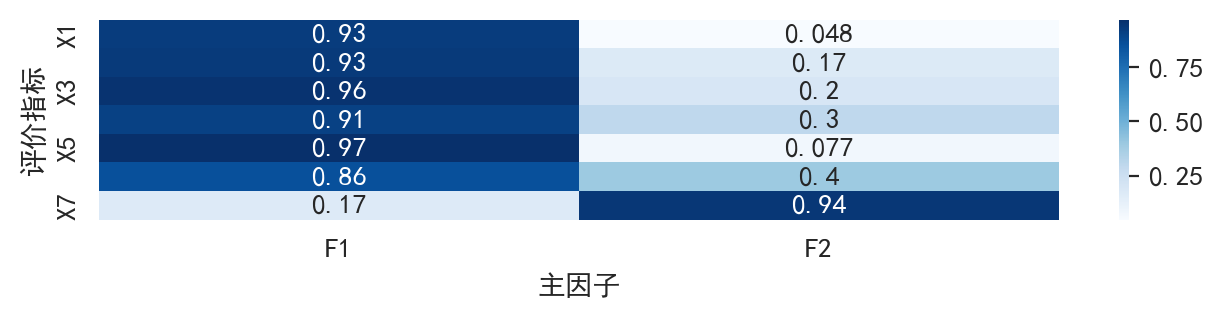

In [13]:
# 因子载荷矩阵：可视化
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False    # 用来正常显示负号

result = pd.DataFrame(fa.loadings_, index=labels,columns=[f'F{i+1}' for i in range(n_factors)])
fig = plt.figure(figsize=(6, 1),dpi=200)
ax = fig.add_axes([0,0,1,1])
sns.heatmap(result.abs(), cmap='Blues', annot=True)
ax.set_xlabel('主因子')
ax.set_ylabel('评价指标')
plt.show()

In [14]:
# 得分系数矩阵
# 课本上用R实现了求取因子得分的函数  : 因子载荷矩阵/主成分特征值
score_mat = fa.loadings_/fa.get_factor_variance()[0]
pd.DataFrame(data=score_mat ,index=labels,columns=["PC1","PC2"])

,PC1,PC2
X1,0.179147,0.039691
X2,0.180238,-0.140960
X3,0.185382,-0.162156
X4,0.175995,-0.245050
X5,0.187605,0.064072
X6,0.165856,0.326941
X7,0.032361,0.779902


In [15]:
# 计算因子得分
score = pd.DataFrame(fa.transform(dataset),index=index, columns=[f'PC{i+1}' for i in range(n_factors)])
score['tol'] = score.dot(fa.get_factor_variance()[1])
score.sort_values(by=['tol'], ascending=False)

,PC1,PC2,tol
地区,,,
山东,2.099442,0.561368,1.645573
河南,1.782183,-0.065548,1.303264
江苏,1.591038,0.296882,1.224875
安徽,0.916860,1.192305,0.882253
河北,1.537198,-1.605158,0.856612
四川,0.959876,-0.219851,0.670055
湖北,0.819439,0.284396,0.653565
浙江,0.787055,0.267176,0.626704
广东,0.800317,0.153547,0.616859


C:\Users\shelhen\AppData\Local\Temp\ipykernel_648\3799751729.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(score['PC1'][i], score['PC2'][i]+0.001, score.index[i], ha='center', va='bottom', fontsize=8)


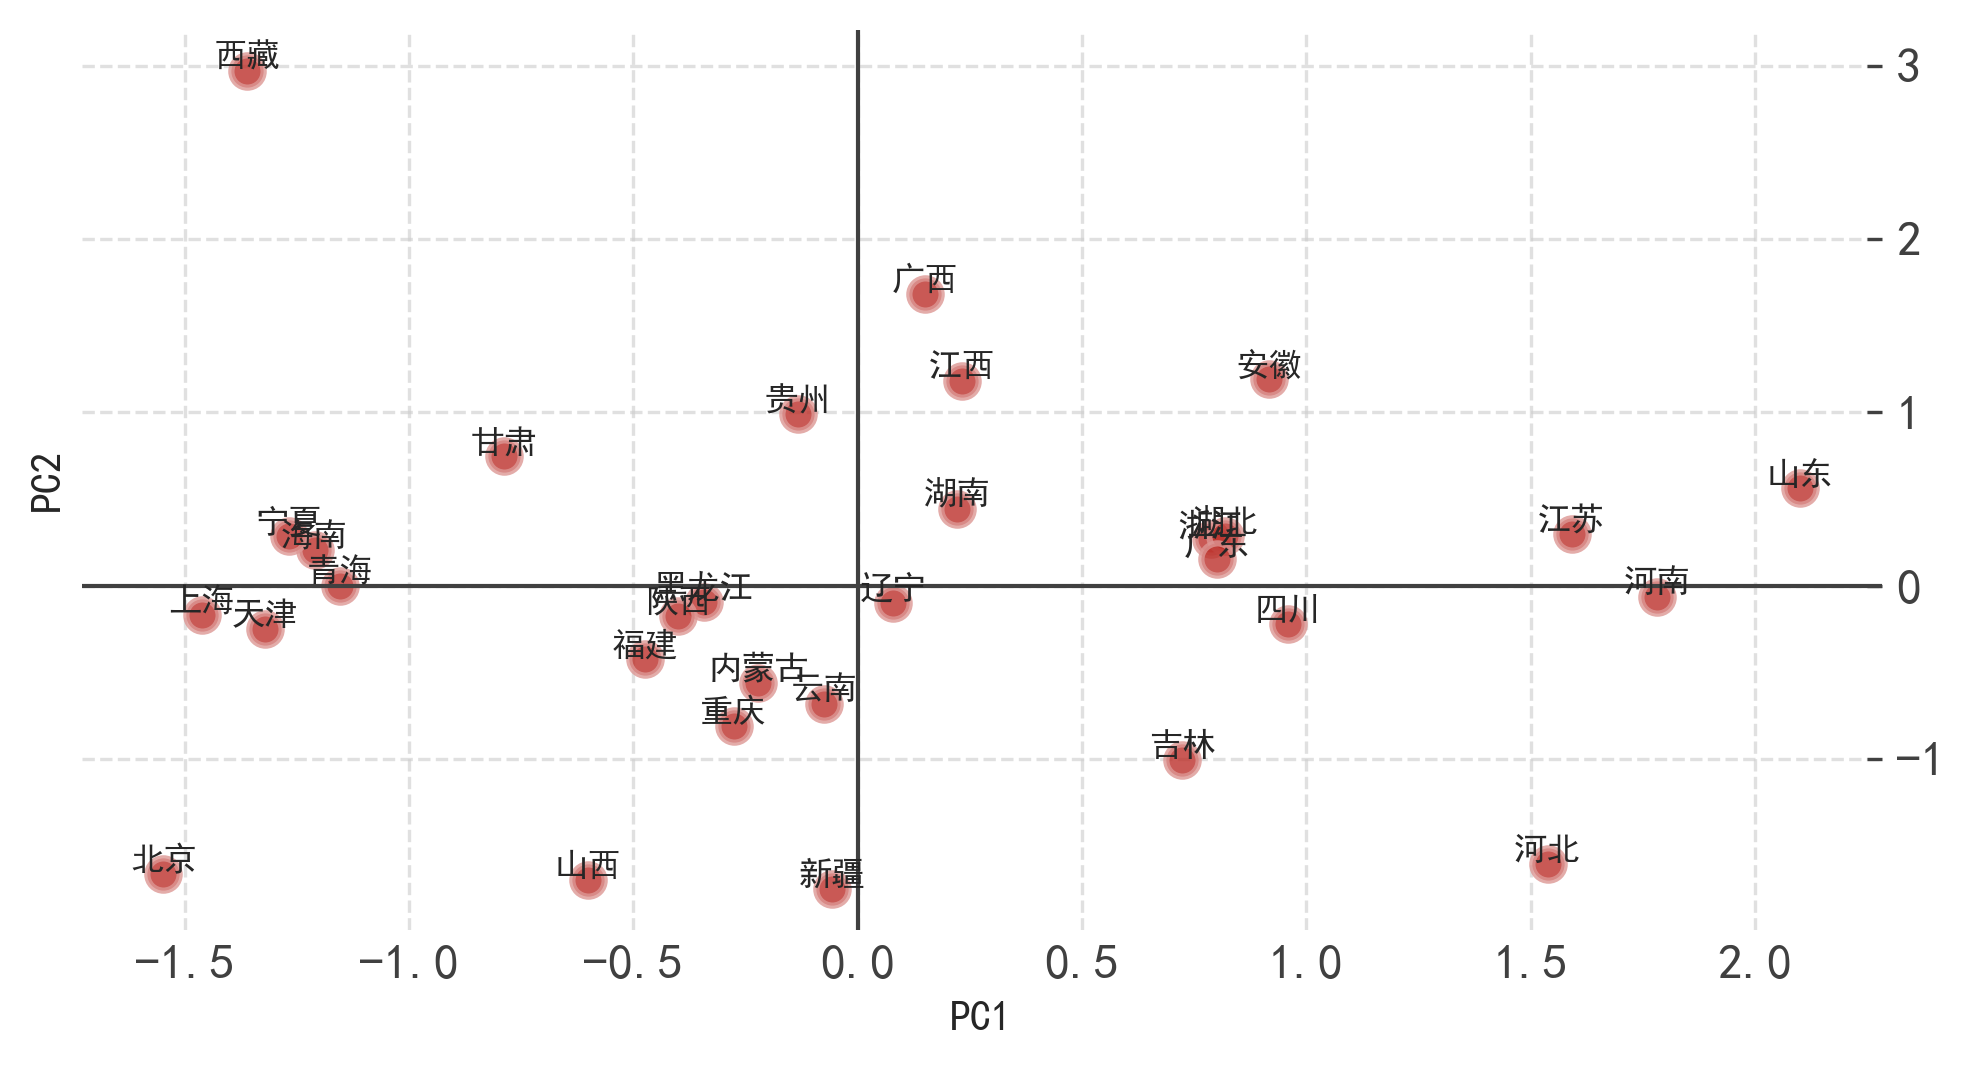

In [16]:
# 绘制得分散点图
import matplotlib.pyplot as plt
# 使用scatter方法绘制散点图

fig = plt.figure(figsize=(6, 3),dpi=300)
ax = fig.add_axes([0,0,1,1])
ax.scatter(score['PC1'], score['PC2'],s=60, c='#BC302A',alpha=0.8,edgecolor='#DD9794', linewidths=1.5)

for i in range(score.shape[0]):
    ax.text(score['PC1'][i], score['PC2'][i]+0.001, score.index[i], ha='center', va='bottom', fontsize=8)
ax.axhline(y=sum(score['PC1'])/31 , color='#404040' , linestyle='-',linewidth=1)
ax.axvline(x=sum(score['PC2'])/31, color='#404040' , linestyle='-',linewidth=1)
ax.tick_params(axis='both',
               labelsize=12, # y轴字体大小设置
               color='#404040',    # y轴标签颜色设置  
               labelcolor='#404040', # y轴字体颜色设置
               direction='in' # y轴标签方向设置
               )
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.grid(ls ='--', c='#ccc', alpha=0.6)
ax.yaxis.tick_right()
for i in ['top', 'right', 'bottom', 'left']:
    ax.spines[i].set_visible(False)
plt.show()

In [17]:
# 因子旋转相关
from factor_analyzer import Rotator
# 得到初始载荷矩阵与公共因子后，为了解释方便，往往需要对因子进行旋转。
# 最常用的正交旋转varimax旋转
rotator = Rotator('varimax')
# 旋转后解析结果
loadings = rotator.fit_transform(fa.loadings_)
# 旋转矩阵
print(rotator.rotation_)
loadings

[[ 0.98164899  0.19069675]
 [-0.19069675  0.98164899]]


array([[ 0.89887736,  0.2235068 ],
       [ 0.94606449,  0.0101573 ],
       [ 0.97702262, -0.00993712],
       [ 0.94855889, -0.11757099],
       [ 0.93612801,  0.26077407],
       [ 0.76527842,  0.55137348],
       [-0.01580157,  0.95757276]])

In [18]:
# 旋转后的系数矩阵及旋转后的因子得分
weights_ = np.linalg.solve(fa.corr_, loadings)
X_scale = (dataset - fa.mean_) / fa.std_
score = X_scale.dot(weights_)
score

,0,1
地区,,
北京,-1.201771,-1.926879
天津,-1.249846,-0.496523
河北,1.815088,-1.282563
山西,-0.266936,-1.780292
内蒙古,-0.110552,-0.591543
辽宁,0.096520,-0.081730
吉林,0.901080,-0.848199
黑龙江,-0.319079,-0.159983
上海,-1.402229,-0.445049


旋转后公共因子解释原始数据的能力没有提高，但因子载荷矩阵及因子得分系数矩阵都发生了变化，因子载荷矩阵中的元素更倾向于0或士1。
有时为了使公共因子的实际意义更容易解释，往往需要放弃公共因子之间互不相关的约束而进行斜交旋转。

In [20]:
# 斜交旋转
from factor_analyzer import Rotator
# np.dot(loadings, phi)
# 最常用的斜交旋转方法为Promax方法。
rotator = Rotator('promax')

# 旋转后解析结果
loadings = rotator.fit_transform(fa.loadings_)
loadings

array([[ 0.89150363,  0.10942867],
       [ 0.96992193, -0.11612608],
       [ 1.00453018, -0.14091706],
       [ 0.9904255 , -0.24771586],
       [ 0.92451475,  0.14274188],
       [ 0.7082774 ,  0.46422365],
       [-0.15073797,  0.98613434]])

In [22]:
# Structure
structure = loadings.dot(rotator.phi_)
structure

array([[0.92020931, 0.34329079],
       [0.93945936, 0.13830697],
       [0.96756436, 0.12259454],
       [0.92544388, 0.01209576],
       [0.96195926, 0.38526357],
       [0.83005405, 0.65002126],
       [0.10794798, 0.94659227]])

Structure Matrix为公共因子与标准化原始变量的相关阵，也就是说，在斜交旋转中，因子载荷系数不再等于公共因子与标准化原始变量的相关系数。

Structure_Matrix = Loading_Matrix.dot(Correlation_Matrix)


由Loading_Matrix可知，变量X2，X3，X4在第一公共因子上的载荷均较大，尤其X3的载荷最大，因此第一公共因子主要反映水泥企业的规模;
变量X6，X7在第二公共因子上的载荷较大，则第二公共因子主要反映水泥企业的盈利能力。
总之，两个公共因子均较未旋转前更容易解释。

In [36]:
from factor_analyzer import FactorAnalyzer

n_factors=2
# 实际上可以在因子分析建模时直接，传入参数rotation='promax'进行旋转
fa = FactorAnalyzer(n_factors=n_factors, rotation='promax', method='principal')
fa.fit(dataset)
fa.loadings_

array([[ 0.89150363,  0.10942867],
       [ 0.96992193, -0.11612608],
       [ 1.00453018, -0.14091706],
       [ 0.9904255 , -0.24771586],
       [ 0.92451475,  0.14274188],
       [ 0.7082774 ,  0.46422365],
       [-0.15073797,  0.98613434]])

In [37]:
fa.structure_

array([[0.92020931, 0.34329079],
       [0.93945936, 0.13830697],
       [0.96756436, 0.12259454],
       [0.92544388, 0.01209576],
       [0.96195926, 0.38526357],
       [0.83005405, 0.65002126],
       [0.10794798, 0.94659227]])

In [38]:
fa.transform(dataset)

array([[-1.44046384, -2.07199911],
       [-1.3034856 , -0.66136282],
       [ 1.63432789, -1.02468107],
       [-0.49452835, -1.80004388],
       [-0.18599213, -0.60106889],
       [ 0.08516112, -0.06789184],
       [ 0.78404231, -0.71822406],
       [-0.33706213, -0.2017592 ],
       [-1.44794933, -0.63101959],
       [ 1.56942202,  0.79338988],
       [ 0.76885727,  0.50638071],
       [ 0.8407036 ,  1.42403337],
       [-0.44691636, -0.55362919],
       [ 0.15805145,  1.19150579],
       [ 2.06033771,  1.20749677],
       [ 1.7828009 ,  0.51181251],
       [ 0.80010363,  0.53311119],
       [ 0.19323823,  0.49158296],
       [ 0.78918137,  0.4030739 ],
       [ 0.04384489,  1.64129826],
       [-1.2210831 , -0.1951711 ],
       [-0.22576654, -0.85339833],
       [ 0.97172062,  0.10094227],
       [-0.19565997,  0.89459278],
       [-0.03257539, -0.66934539],
       [-1.54324497,  2.37514993],
       [-0.38799445, -0.29435449],
       [-0.83440085,  0.45276288],
       [-1.15219174,